In [1]:
%matplotlib inline

from glob import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [2]:
LABELS = {
    'ky.matc'       : 'Entropy-Optimal Sampler',
    'ky.enc'        : 'Entropy-Optimal Sampler',
    'rej.binary'    : 'Rejection Sampler (Dyadic; Binary Search)',
    'rej.table'     : 'Rejection Sampler (Dyadic; Lookup Table)',
    'rej.matc'      : 'Rejection Sampler (Dyadic; New Method)',
    'rej.enc'       : 'Fast Loaded Dice Roller (FLDR)',
    'rej.uniform'   : 'Rejection Sampler (Uniform)',
    'interval'      : 'Exact Interval Sampler',
    'boost.alias'   : 'Alias Sampler',
    'std.inversion' : 'Inversion Sampler',
    'alias.exact'   : 'Exact Alias Sampler',
}

In [3]:
def get_entropy(fname):
    with open(fname, 'r') as f:
        data = f.readlines()
        return float(data[-1])

In [4]:
n = 1000
Z = 40001
seed = 2
pattern = 'dists.%d.%d.%d' % (n, Z, seed)
f_runtimes = sorted(glob('../%s/*.runtimes' % (pattern,)))
f_sizes = sorted(glob('../%s/*.sizes' % (pattern,)))
f_dists = sorted(glob('../%s/*.dist' % (pattern,)))
runtimes = np.asarray([np.loadtxt(f) for f in f_runtimes])
sizes = np.asarray([np.loadtxt(f) for f in f_sizes])
entropies = np.asarray([get_entropy(f) for f in f_dists])
num_samples = 1e6
rates = runtimes / num_samples
samplers = [x.split('/')[-1].replace('.runtimes', '') for x in f_runtimes]

In [5]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'sans-serif'

#### Plot Memory--Rate

In [6]:
selection = [
    'rej.enc',
    'ky.enc',
    'rej.binary',
    'rej.uniform',
    'rej.table',
    'interval',
    'alias.exact',
]

In [7]:
samplers

['alias.exact',
 'interval',
 'ky.enc',
 'rej.binary',
 'rej.enc',
 'rej.matc',
 'rej.table',
 'rej.uniform']

In [8]:
def run_plot_rate_size(samplers, rates, sizes):
    fig, ax = plt.subplots()
    for sampler, rate, size in zip(samplers, rates, sizes):
        if sampler not in selection:
            continue
        print(sampler)
        ax.scatter(rate, size, label=LABELS[sampler], s=10, marker='.', alpha=1)

    ax.set_xscale('log', basex=2)
    ax.set_yscale('log', basey=2)

    ax.set_xlabel('Sampler Runtime (Seconds per Sample)', fontsize=14)
    ax.set_ylabel('Sampler Memory (Bytes)', fontsize=14)

    ax.xaxis.set_major_locator(
        ticker.LogLocator(base=2., subs=(1,), numticks=100))
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_locator(
        ticker.LogLocator(base=2., subs=np.arange(11, 20)*.1, numticks=24))

    ax.yaxis.set_major_locator(
        ticker.LogLocator(base=2., subs=(1,), numticks=20))
    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    ax.yaxis.set_minor_locator(
        ticker.LogLocator(base=2., subs=np.arange(11,20)*.1, numticks=100))

    fig.set_size_inches((8, 6))
    fig.set_facecolor('white')
    fig.set_tight_layout(True)
    
    return fig, ax

alias.exact
interval
ky.enc
rej.binary
rej.enc
rej.table
rej.uniform


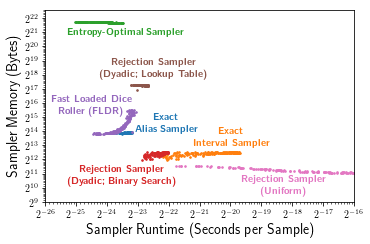

In [9]:
fig, ax = run_plot_rate_size(samplers, rates, sizes)

ax.set_xlim([2**-26, 2**-16])
ax.set_ylim([2**9, 1.5*2**22])

# ax.grid(linestyle='-', which='major')
# ax.grid(linestyle='-', which='minor', axis='y')
# ax.legend(loc='lower left', handletextpad=0)

ax.text(
    0.95*2**-22, 2**14,
    r'\begin{center}\textbf{Exact}\\\textbf{Alias Sampler}\end{center}',
    horizontalalignment='center',
    color=ax.get_children()[0].get_facecolors()[0])
ax.text(
    2**-20, 2**13,
    r'\begin{center}\textbf{Exact}\\\textbf{Interval Sampler}\end{center}',
    horizontalalignment='center',
    color=ax.get_children()[1].get_facecolors()[0])
ax.text(
    1.5*2**-24, 1.8*2**20,
    r'\textbf{Entropy-Optimal Sampler}',
    horizontalalignment='center',
    color=ax.get_children()[2].get_facecolors()[0])
ax.text(
    1.4*2**-24, 1.2*2**10,
    r'\begin{center}\textbf{Rejection Sampler}\\\textbf{(Dyadic; Binary Search)}\end{center}',
    horizontalalignment='center',
    color=ax.get_children()[3].get_facecolors()[0])
ax.text(
    0.7*2**-24, 1.2*2**15,
    r'\begin{center}\textbf{Fast Loaded Dice}\\\textbf{Roller (FLDR)}\end{center}',
    horizontalalignment='center',
    color=ax.get_children()[4].get_facecolors()[0])
ax.text(
    1.4*2**-23, 1.8*2**17,
    r'\begin{center}\textbf{Rejection Sampler}\\\textbf{(Dyadic; Lookup Table)}\end{center}',
    horizontalalignment='center',
    color=ax.get_children()[5].get_facecolors()[0])
ax.text(
    1.6*2**-19, 1.5*2**9,
    r'\begin{center}\textbf{Rejection Sampler}\\\textbf{(Uniform)}\end{center}',
    horizontalalignment='center',
    color=ax.get_children()[6].get_facecolors()[0])

fig.set_tight_layout(True)
fig.set_size_inches(5.25, 3.5)
for ext in ['pdf', 'png']:
    fig.savefig('figure-4-sampler-comparison-runtime-memory.%s' % (ext,))

#### Plot Entropy--Rate

In [10]:
from scipy.signal import savgol_filter

In [11]:
def run_plot_entropy_rate(samplers, entropies, rate):
    fig, ax = plt.subplots()

    for sampler, rate in zip(samplers, rates):
        if sampler not in selection:
            continue
        print(sampler, len(entropies), len(rate))
        # yhat = savgol_filter(rate, 21, 3) # window size 51, polynomial order 3
        yhat = rate
        sc = ax.scatter([], [], label=r'\textbf{%s}' %(LABELS[sampler],), marker='.', s=50)
        c = sc.get_facecolors()[0]
        ax.scatter(entropies, yhat, color=c, marker='.', s=2)

    ax.set_yscale('log', basey=2)
    ax.set_xlabel('Entropy of Target Distribution', fontsize=14)
    ax.set_ylabel('Sampler Runtime (Seconds per Sample)', fontsize=12)

    ax.yaxis.set_minor_formatter(ticker.NullFormatter())
    ax.yaxis.set_minor_locator(
        ticker.LogLocator(base=2., subs=np.arange(11, 20)*.1, numticks=24))
    ax.yaxis.set_major_locator(
        ticker.LogLocator(base=2., subs=(1,), numticks=12))

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(.25))
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))

    fig.set_tight_layout(True)
    fig.set_facecolor('white')
    fig.set_size_inches((8, 6))
    
    return fig, ax

alias.exact 200 200
interval 200 200
ky.enc 200 200
rej.binary 200 200
rej.enc 200 200
rej.table 200 200
rej.uniform 200 200


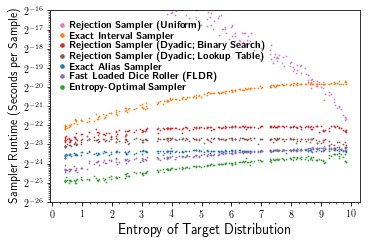

In [12]:
fig, ax = run_plot_entropy_rate(samplers, entropies, rates)

# ax.set_xlim([0, 10.25])
ax.set_ylim([2**-26, 2**-16])

handles, labels = ax.get_legend_handles_labels()
order = [6, 1, 3, 5, 0, 4, 2]
ax.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    loc='upper left',
    framealpha=0,
    labelspacing=0,
    handletextpad=.5,
    handlelength=.5,
#     bbox_to_anchor=(1,1),
)

fig.set_tight_layout(True)
fig.set_size_inches(5.25, 3.5)
for ext in ['pdf', 'png']:
    fig.savefig('figure-4-sampler-comparison-entropy-runtime.%s' % (ext,))